In [ ]:
# 必要なライブラリをインストール
!pip install japanize_matplotlib
!pip install pmdarima

In [2]:
# ライブラリを起動
from dateutil.relativedelta import relativedelta
import japanize_matplotlib
import math as math
import numpy as np
import pandas as pd
import scipy as sp
import random
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.linear_model import LinearRegression
from scipy.special import comb
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15, 6
# Colabでファイルを読み込むために、Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# (3) インパルス応答関数の信頼区間

## (3-1)ARモデルのインパルス応答関数の信頼区間

*   変数には、GDPギャップ（日本銀行が推計している需給ギャップ、1983年第1四半期から2023年第4四半期まで）を用いる

In [ ]:
# データの読み込み
dinput = pd.read_excel("/content/drive/My Drive/Data/data_VAR3.xlsx",
                       sheet_name="data_q", header=[0])
data = np.zeros([len(dinput), 1])
for i in range(1, len(dinput)):
    data[:, 0] = dinput.gapboj
data = data[44:]
dlen = len(data)

### (3-1-1) デルタ法による信頼区間

AR(1)モデルとAR(2)モデルでインパルス応答関数のデルタ法による信頼区間を計算する

*   実線がインパルス応答関数、破線が信頼区間
*   ショックのサイズは1標準偏差
*   信頼区間の幅は90\%ile

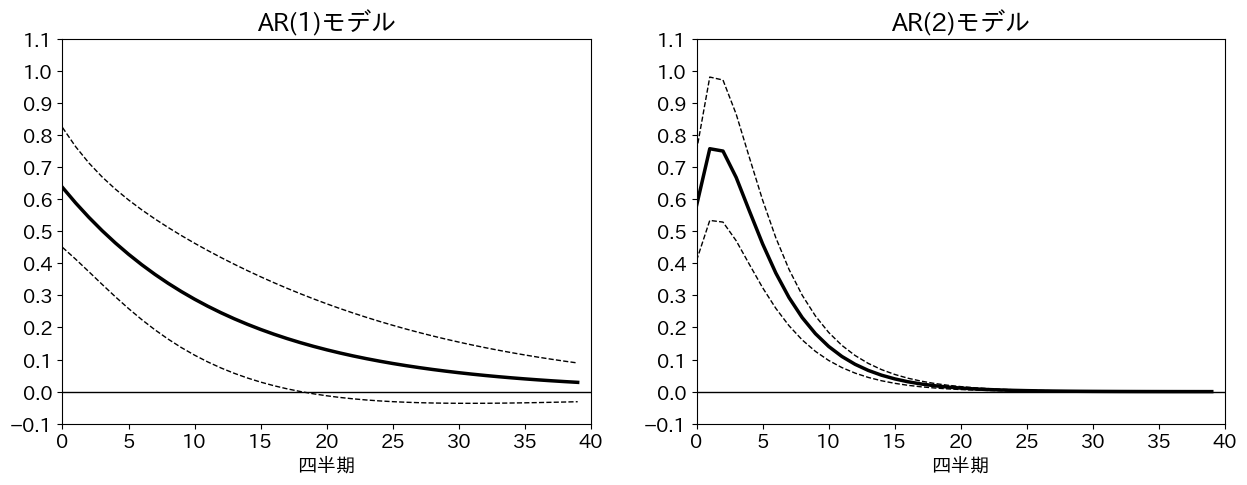

In [ ]:
# インパルス応答関数と信頼区間
L = 2
MAX_H = 40
CONFIDENCE_LEVEL = 0.90
ssize = len(data)
plt.figure(figsize=(15, 5))
predict_result = np.zeros(MAX_H + 1)
se_result = np.zeros(MAX_H)
lbound, ubound = sp.stats.norm.interval(confidence=CONFIDENCE_LEVEL, loc=0,
                                        scale=1)


def calc_covmat(x, y, prediction):
    var_hat_y = np.sum((y - prediction) ** 2) / (len(y) - x.shape[1])
    var = np.linalg.inv(np.matmul(x.T, x)) * var_hat_y.to_numpy()
    return var


for l in range(1, L+1, 1):
    sample_x, sample_y = pd.DataFrame(), pd.DataFrame(data[L : ssize])
    for ll in range(1, l + 1):
        sample_x_lagged = pd.DataFrame(
            data[L - ll : L - ll + len(sample_y)]
            )
        sample_x = pd.concat([sample_x, sample_x_lagged], axis=1)
    sample_x_adj = sm.add_constant(sample_x, has_constant='add')
    model = LinearRegression()
    model.fit(sample_x, sample_y)
    y_hat = model.predict(sample_x)
    resid = sample_y - y_hat
    sigma = (np.sum(resid ** 2, axis=0) / len(resid)) ** (1 / 2)
    predict_result[0] = sigma
    extra_x = pd.DataFrame(pd.concat([sigma,
                                      pd.DataFrame([np.zeros(l)])],
                                     axis=1).to_numpy())
    extra_x = extra_x.iloc[:, :l]
    temp = 1
    for h in range(0, MAX_H, 1):
        forecast = pd.DataFrame([np.sum((extra_x * model.coef_).to_numpy())])
        if l == 1:
            phi = model.coef_[0, 0]
            fphi = sigma * h * (phi ** (h-1))
            fsigma = (phi ** h) / (2 * sigma)
            vhat = sigma ** 2 / (np.sum(sample_y ** 2, axis=0) / len(sample_y))
            what = np.sum(resid ** 4) / len(resid) - (np.sum(resid ** 2) /
                                                      len(resid)) ** 2
            seband = (((fphi ** 2) * vhat + (fsigma ** 2) * what) /
                      len(sample_y)) ** (1 / 2)
        elif l == 2:
            phi1 = model.coef_[0, 0]
            phi2 = model.coef_[0, 1]
            fphi1 = 0
            for ii in range(0, math.floor(h / 2) + 1):
                fphi1 += sigma * (h - 2 * ii) * (phi1 ** (h - 2 * ii -1)) * (
                    phi2 ** ii) * comb(h - ii, ii, exact=True)
            fphi2 = 0
            for ii in range(0, math.floor(h / 2) + 1):
                fphi2 += sigma * ii * (phi1 ** (h - 2 * ii)) * (
                    phi2 ** (ii - 1)) * comb(h - ii, ii, exact=True)
            fsigma = 0
            for ii in range(0, math.floor(h / 2) + 1):
                fsigma += ((phi1 ** (h - 2 * ii)) * (phi2 ** ii) * comb(
                    h - ii, ii, exact=True)) / (2 * sigma)
            covmat = calc_covmat(sample_x_adj, sample_y, model.predict(
                sample_x))
            v1hat = covmat[1,1]
            v2hat = covmat[2,2]
            v12hat = covmat[1,2]
            what = np.sum(resid ** 4) / len(resid) - (np.sum(resid ** 2) /
                                                      len(resid)) ** 2
            seband = (((fphi1 ** 2) * v1hat + (fphi2 ** 2) * v2hat
                       + 2 * fphi1 * fphi2 * v12hat + (fsigma ** 2) * what) /
                      len(sample_y)) ** (1 / 2)
        extra_x = pd.concat([forecast,
                             pd.DataFrame((extra_x.T[:-1]).T.to_numpy())],
                            axis=1)
        predict_result[h + 1] = np.squeeze(np.array(forecast))
        se_result[h] = np.squeeze(np.array(seband))
        temp = forecast
    impulse = predict_result[:-1]
    lb = impulse + lbound * se_result
    ub = impulse + ubound * se_result
    # グラフの描画
    plt.subplot(1, 2, l)
    plt.plot(impulse, linestyle='solid', color='black', linewidth=2.5)
    plt.plot(lb, linestyle='dashed', color='black', linewidth=1)
    plt.plot(ub, linestyle='dashed', color='black', linewidth=1)
    plt.title('AR(%i)モデル' %l, fontsize=18)
    plt.xlabel("四半期", fontsize=14)
    plt.tick_params(labelsize=14)
    plt.xlim(0, MAX_H)
    plt.hlines([0], 0, MAX_H, color='black', linewidth=1)
    plt.yticks(np.arange(-0.1, 1.11, step=0.1))

### (3-1-2) ブートストラップによる信頼区間

AR(1)モデルとAR(2)モデルでインパルス応答関数のブートストラップによる信頼区間を計算する

*   実線がインパルス応答関数、破線が信頼区間
*   ショックのサイズは1標準偏差
*   信頼区間の幅は90\%ile
*   試行回数はB=2000回

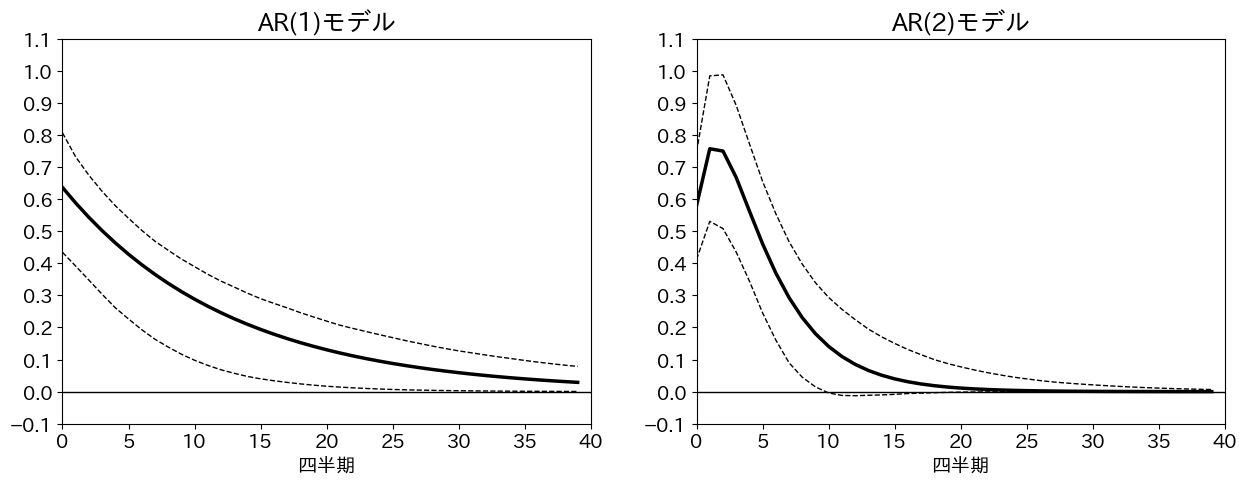

In [ ]:
# インパルス応答関数
L = 2
MAX_H = 40
CONFIDENCE_LEVEL = 0.90
NDRAWS = 2000
ssize = len(data)
plt.figure(figsize=(15, 5))
predict_result = np.zeros(MAX_H)
se_result_bsbox = np.zeros([NDRAWS, MAX_H])
significance = 1 - CONFIDENCE_LEVEL

for l in range(1, L+1, 1):
    sample_x, sample_y = pd.DataFrame(), pd.DataFrame(data[L : ssize])
    for ll in range(1, l + 1):
        sample_x_lagged = pd.DataFrame(
            data[L - ll : L - ll + len(sample_y)]
            )
        sample_x = pd.concat([sample_x, sample_x_lagged], axis=1)
    model = LinearRegression()
    model.fit(sample_x, sample_y)
    y_hat = model.predict(sample_x)
    resid = np.std(sample_y - y_hat)
    predict_result[0] = resid
    extra_x = pd.DataFrame(pd.concat([resid,
                                      pd.DataFrame([np.zeros(l)])],
                                     axis=1).to_numpy())
    extra_x = extra_x.iloc[:, :l]
    for h in range(1, MAX_H, 1):
        forecast = pd.DataFrame([np.sum((extra_x * model.coef_).to_numpy())])
        extra_x = pd.concat([forecast,
                             pd.DataFrame((extra_x.T[:-1]).T.to_numpy())],
                            axis=1)
        predict_result[h] = np.squeeze(np.array(forecast))
    impulse = predict_result
    # 信頼区間
    tt = 0
    y_artificial = np.zeros([len(sample_y), 1])
    while tt < NDRAWS:
        predict_result_bs = np.zeros(MAX_H)
        u = random.choices(np.array(sample_y - y_hat), k=len(sample_y))
        y_artificial = data[0 : l]
        for i in range(0, len(sample_y), 1):
            y_artificial = np.append(y_artificial,
                                     np.sum(np.flip(y_artificial[-l : ]) *
                                            model.coef_)
                                     + np.squeeze(u[i]))
        sample_x_bs, sample_y_bs = pd.DataFrame(), pd.DataFrame(
            y_artificial[L : ])
        for ll in range(1, l + 1):
            sample_x_lagged_bs = pd.DataFrame(
                y_artificial[L - ll : L - ll + len(sample_y_bs)])
            sample_x_bs = pd.concat([sample_x_bs, sample_x_lagged_bs], axis=1)
        model_bs = LinearRegression()
        model_bs.fit(sample_x_bs, sample_y_bs)
        y_hat_bs = model_bs.predict(sample_x_bs)
        resid_bs = np.std(sample_y_bs - y_hat_bs)
        predict_result_bs[0] = resid_bs
        extra_x_bs = pd.DataFrame(pd.concat([resid_bs,
                                             pd.DataFrame([np.zeros(l)])],
                                            axis=1).to_numpy())
        extra_x_bs = extra_x_bs.iloc[:, :l]
        for h in range(1, MAX_H, 1):
            forecast_bs = pd.DataFrame([np.sum((extra_x_bs *
                                                model_bs.coef_).to_numpy())])
            extra_x_bs = pd.concat([forecast_bs,
                                    pd.DataFrame((extra_x_bs.T[:-1]).T.
                                                 to_numpy())], axis=1)
            predict_result_bs[h] = np.squeeze(np.array(forecast_bs))
        se_result_bsbox[tt, :] = predict_result_bs
        tt = tt + 1
    lband = pd.DataFrame(se_result_bsbox).quantile(1 - significance / 2)
    uband = pd.DataFrame(se_result_bsbox).quantile(significance / 2)
    # グラフの描画
    plt.subplot(1, 2, l)
    plt.plot(impulse, linestyle='solid', color='black', linewidth=2.5)
    plt.plot(pd.DataFrame(lband), linestyle='dashed', color='black',
             linewidth=1)
    plt.plot(pd.DataFrame(uband), linestyle='dashed', color='black',
             linewidth=1)
    plt.title('AR(%i)モデル' %l, fontsize=18)
    plt.xlabel("四半期", fontsize=14)
    plt.tick_params(labelsize=14)
    plt.xlim(0, MAX_H)
    plt.hlines([0], 0, MAX_H, color='black', linewidth=1)
    plt.yticks(np.arange(-0.1, 1.11, step=0.1))

## (3-2)VARモデルのインパルス応答関数の信頼区間

*   変数には、物価水準と金利の2変数（1972年第1四半期から2023年第4四半期まで）を用いる

In [3]:
# データの読み込み
dinput = pd.read_excel("/content/drive/My Drive/Data/data_VAR3.xlsx",
                       sheet_name="data_q", header=[0])
data = np.zeros([len(dinput), 2])
for i in range(1, len(dinput)):
    data[:, 0] = np.log(dinput.cpi)
    temp = pm.arima.decompose(data[:, 0], 'additive', m=4)
    data[:, 0] = (np.log(dinput.cpi) - temp.seasonal) *100
    data[:, 1] = dinput.RSR
dlen = len(data)

## (3-2-1) デルタ法による信頼区間

*   実線がインパルス応答関数、破線が信頼区間
*   ショックのサイズは1標準偏差
*   信頼区間の幅は90\%ile
*   ラグ次数はAICに基づき、5が選択される


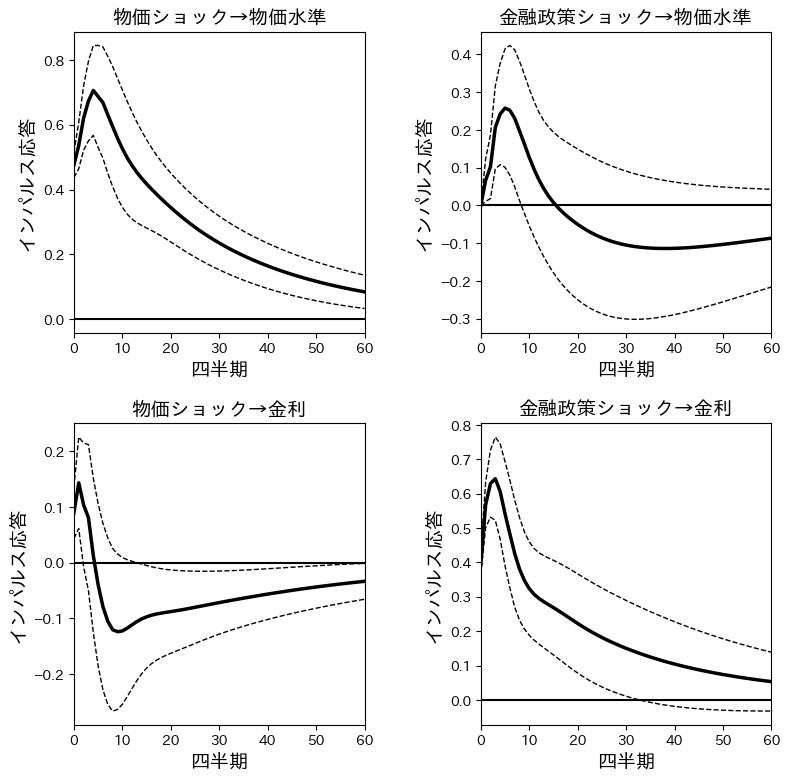

In [4]:
# VARモデルの推定
CONFIDENCE_LEVEL = 0.9
lbound, ubound = sp.stats.norm.interval(confidence=CONFIDENCE_LEVEL, loc=0,
                                        scale=1)
model = VAR(data)
PERIOD = 60
results = model.fit(maxlags=20, ic="aic")
irf = results.irf(PERIOD)
impulse = irf.orth_irfs
lband_delta = impulse + irf.stderr(orth=True) * lbound
uband_delta = impulse + irf.stderr(orth=True) * ubound

# グラフの描画
vnames = ['物価水準', '金利']
snames = ['物価ショック', '金融政策ショック']
fig, ax = plt.subplots(2, 2, figsize=[9, 9])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(impulse[:,i,j], linewidth=2.5, color='black')
        ax[i,j].plot(lband_delta[:,i,j], linewidth=1, linestyle='dashed',
                     color='black')
        ax[i,j].plot(uband_delta[:,i,j], linewidth=1, linestyle='dashed',
                     color='black')
        ax[i,j].hlines([0], 0, PERIOD, color='black', linestyle='solid')
        ax[i,j].set_xlim(0, PERIOD)
        ax[i,j].set_xlabel('四半期', fontsize=14)
        ax[i,j].set_ylabel('インパルス応答', fontsize=14)
        ax[i,j].set_title('%s→%s' %(snames[j],vnames[i]), fontsize=14)
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

## (3-2-2) ブートストラップによる信頼区間

*   実線がインパルス応答関数、破線が信頼区間
*   ショックのサイズは1標準偏差
*   信頼区間の幅は90\%ile
*   ラグ次数はAICに基づき、5が選択される
*   試行回数はB=2000回

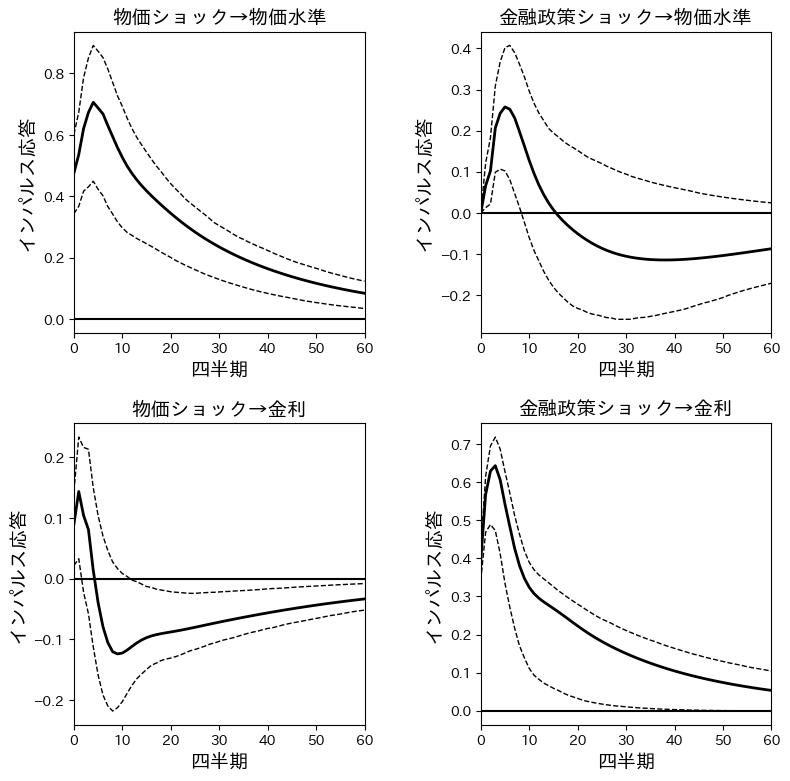

In [5]:
# VARモデルの推定
SIGNIFICANCE_LEVEL = 0.1
NDRAWS = 2000
PERIOD = 60

model = VAR(data)
results = model.fit(maxlags=20, ic="aic")
lag = results.k_ar
irf = results.irf(PERIOD)
impulse = irf.orth_irfs
impulse_1 = impulse[:, 0][:, 0]
impulse_2 = impulse[:, 0][:, 1]
impulse_3 = impulse[:, 1][:, 0]
impulse_4 = impulse[:, 1][:, 1]
impulse_bs_1 = np.zeros([NDRAWS, PERIOD + 1])
impulse_bs_2 = np.zeros([NDRAWS, PERIOD + 1])
impulse_bs_3 = np.zeros([NDRAWS, PERIOD + 1])
impulse_bs_4 = np.zeros([NDRAWS, PERIOD + 1])

tt = 0
while tt< NDRAWS:
    bs_resid = pd.DataFrame()
    for i in range(len(data) - lag):
            random_resid = random.choice(results.resid)
            random_resid = random_resid.reshape(1, -1)
            df_resid = pd.DataFrame(random_resid)
            bs_resid = pd.concat([bs_resid, df_resid], ignore_index = True)
    bs_resid.columns= ["y1", "y2"]
    initial_data = data[ : 5]
    input_data = initial_data
    bootstrap_sample = initial_data
    for j in range(0, len(data) - lag):
        forecast_values = results.forecast(y=input_data, steps=1)
        forecast = np.array([forecast_values[0][0] + bs_resid["y1"][j],
                             forecast_values[0][1] + bs_resid["y2"][j]])
        forecast = forecast.reshape(1, -1)
        combined_data = np.vstack([input_data, forecast])
        input_data = combined_data[1 : ]
        bootstrap_sample = np.vstack([bootstrap_sample, forecast])
    model_bs = VAR(bootstrap_sample)
    results_bs = model_bs.fit(lag)
    irf_bs = results_bs.irf(PERIOD)
    impulse_bs = irf_bs.orth_irfs
    impulse_bs_1[tt, :] = impulse_bs[:, 0][:, 0]
    impulse_bs_2[tt, :] = impulse_bs[:, 0][:, 1]
    impulse_bs_3[tt, :] = impulse_bs[:, 1][:, 0]
    impulse_bs_4[tt, :] = impulse_bs[:, 1][:, 1]
    tt=tt+1

# グラフの描画
vnames = ['物価水準', '金利']
snames = ['物価ショック', '金融政策ショック']
fig, ax = plt.subplots(2, 2, figsize=[9, 9])
counter = 0
for i in range(2):
    for j in range(2):
        ax[i,j].plot(globals()[f"impulse_{1+counter}"], linewidth=2,
                     color='black')
        ax[i,j].plot(pd.DataFrame(globals()[f"impulse_bs_{1+counter}"]
                                  ).quantile(SIGNIFICANCE_LEVEL / 2),
                     linewidth=1, linestyle='dashed', color='black')
        ax[i,j].plot(pd.DataFrame(globals()[f"impulse_bs_{1+counter}"]
                                  ).quantile(1 - SIGNIFICANCE_LEVEL / 2),
                     linewidth=1, linestyle='dashed', color='black')
        ax[i,j].hlines([0], 0, PERIOD, color='black', linestyle='solid')
        ax[i,j].set_xlim(0, PERIOD)
        ax[i,j].set_xlabel('四半期', fontsize=14)
        ax[i,j].set_ylabel('インパルス応答', fontsize=14)
        ax[i,j].set_title('%s→%s' %(snames[j],vnames[i]), fontsize=14)
        counter = counter + 1
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

ここで、デルタ法による信頼区間（赤色の点線）とブートストラップによる信頼区間（青色の破線）を比較すると、以下のようになる。

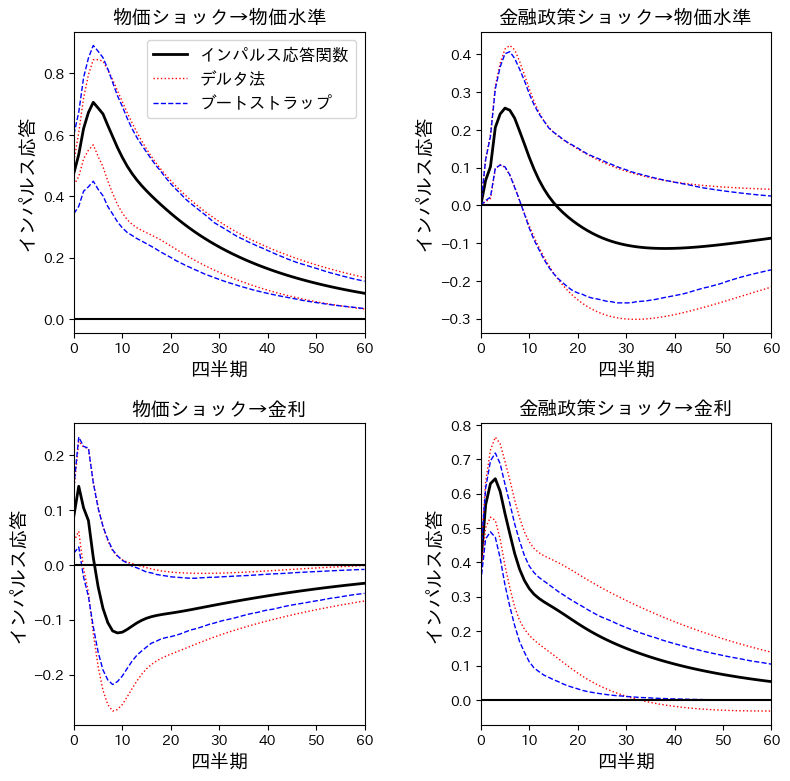

In [7]:
# グラフの描画
vnames = ['物価水準', '金利']
snames = ['物価ショック', '金融政策ショック']
fig, ax = plt.subplots(2, 2, figsize=[9, 9])
counter = 0
for i in range(2):
    for j in range(2):
        ax[i,j].plot(globals()[f"impulse_{1+counter}"], linewidth=2,
                     color='black', label='インパルス応答関数')
        ax[i,j].plot(lband_delta[:,i,j], linewidth=1, linestyle='dotted',
                     color='red', label='デルタ法')
        ax[i,j].plot(uband_delta[:,i,j], linewidth=1, linestyle='dotted',
                     color='red')
        ax[i,j].plot(pd.DataFrame(globals()[f"impulse_bs_{1+counter}"]
                                  ).quantile(SIGNIFICANCE_LEVEL / 2),
                     linewidth=1, linestyle='dashed', color='blue',
                     label='ブートストラップ')
        ax[i,j].plot(pd.DataFrame(globals()[f"impulse_bs_{1+counter}"]
                                  ).quantile(1 - SIGNIFICANCE_LEVEL / 2),
                     linewidth=1, linestyle='dashed', color='blue')
        ax[i,j].hlines([0], 0, PERIOD, color='black', linestyle='solid')
        ax[i,j].set_xlim(0, PERIOD)
        ax[i,j].set_xlabel('四半期', fontsize=14)
        ax[i,j].set_ylabel('インパルス応答', fontsize=14)
        ax[i,j].set_title('%s→%s' %(snames[j],vnames[i]), fontsize=14)
        ax[0,0].legend(loc='upper right', fontsize=12)
        counter = counter + 1
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

## (練習問題2) 残差の再帰的ブートストラップにおいて、初期値を固定しない方法（初期値をMoving Block Bootstrapによる値とする方法）

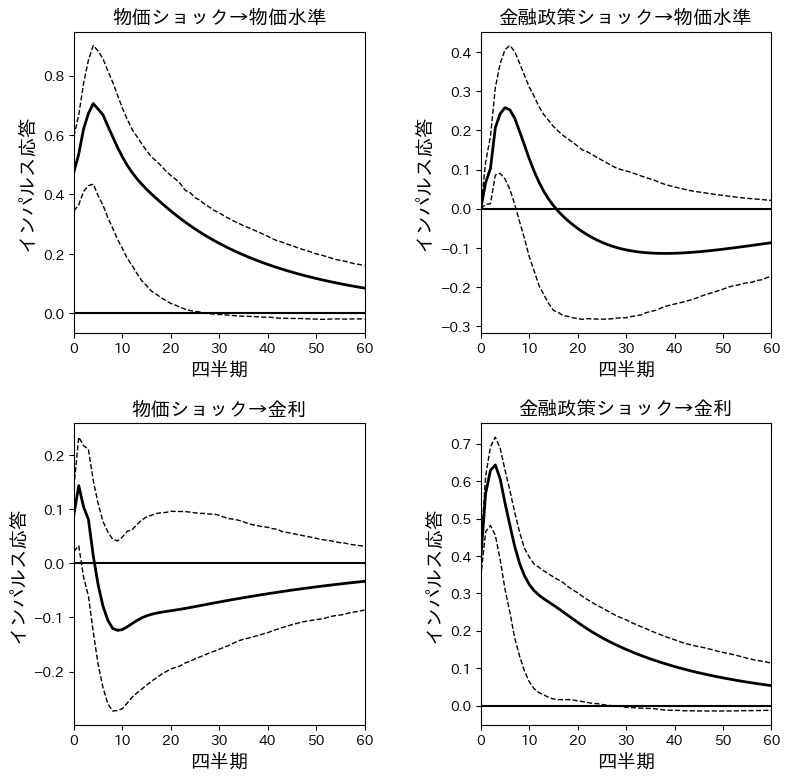

In [ ]:
# 初期値の設定
block_size = 5
block_num = int(len(data) - block_size + 1)
blocks = []
n = len(data)
for start in range(n - block_size + 1):
    block = data[start : start + block_size]
    blocks.append(block)

# インパルス応答関数
SIGNIFICANCE_LEVEL = 0.1
NDRAWS = 2000
PERIOD = 60
model = VAR(data)
results = model.fit(maxlags=20, ic="aic")
lag = results.k_ar
irf = results.irf(PERIOD)
impulse = irf.orth_irfs
impulse_1 = impulse[:, 0][:, 0]
impulse_2 = impulse[:, 0][:, 1]
impulse_3 = impulse[:, 1][:, 0]
impulse_4 = impulse[:, 1][:, 1]
impulse_bs_1 = np.zeros([NDRAWS, PERIOD+1])
impulse_bs_2 = np.zeros([NDRAWS, PERIOD+1])
impulse_bs_3 = np.zeros([NDRAWS, PERIOD+1])
impulse_bs_4 = np.zeros([NDRAWS, PERIOD+1])

tt = 0
while tt< NDRAWS:
    bs_resid = pd.DataFrame()
    for i in range(len(data) - lag):
            random_resid = random.choice(results.resid)
            random_resid = random_resid.reshape(1, -1)
            df_resid = pd.DataFrame(random_resid)
            bs_resid = pd.concat([bs_resid, df_resid], ignore_index = True)
    bs_resid.columns= ["y1", "y2"]
    initial_data = random.choice(blocks)
    input_data = initial_data
    bootstrap_sample = initial_data
    for j in range(0, len(data) - lag):
        forecast_values = results.forecast(y=input_data, steps=1)
        forecast = np.array([forecast_values[0][0] + bs_resid["y1"][j],
                             forecast_values[0][1] + bs_resid["y2"][j]])
        forecast = forecast.reshape(1, -1)
        combined_data = np.vstack([input_data, forecast])
        input_data = combined_data[1 : ]
        bootstrap_sample = np.vstack([bootstrap_sample, forecast])
    model_bs = VAR(bootstrap_sample)
    results_bs = model_bs.fit(lag)
    irf_bs = results_bs.irf(PERIOD)
    impulse_bs = irf_bs.orth_irfs
    impulse_bs_1[tt, :] = impulse_bs[:, 0][:, 0]
    impulse_bs_2[tt, :] = impulse_bs[:, 0][:, 1]
    impulse_bs_3[tt, :] = impulse_bs[:, 1][:, 0]
    impulse_bs_4[tt, :] = impulse_bs[:, 1][:, 1]
    tt=tt+1

# グラフの描画
vnames = ['物価水準', '金利']
snames = ['物価ショック', '金融政策ショック']
fig, ax = plt.subplots(2, 2, figsize=[9, 9])
counter = 0
for i in range(2):
    for j in range(2):
        ax[i,j].plot(globals()[f"impulse_{1+counter}"], linewidth=2,
                     color='black')
        ax[i,j].plot(pd.DataFrame(globals()[f"impulse_bs_{1+counter}"]
                                  ).quantile(SIGNIFICANCE_LEVEL / 2),
                     linewidth=1, linestyle='dashed', color='black')
        ax[i,j].plot(pd.DataFrame(globals()[f"impulse_bs_{1+counter}"]
                                  ).quantile(1 - SIGNIFICANCE_LEVEL / 2),
                     linewidth=1, linestyle='dashed', color='black')
        ax[i,j].hlines([0], 0, PERIOD, color='black', linestyle='solid')
        ax[i,j].set_xlim(0, PERIOD)
        ax[i,j].set_xlabel('四半期', fontsize=14)
        ax[i,j].set_ylabel('インパルス応答', fontsize=14)
        ax[i,j].set_title('%s→%s' %(snames[j],vnames[i]), fontsize=14)
        counter = counter + 1
plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()